# W207 Final Project
## Kaggle Competition: Forest Cover Prediction
**Pierce Coggins, Jake Mitchell, Debasish Mukhopadhyay, and Tim Slade**

## The Task
In this assignment, we will attempt to predict the forest cover type (defined as the predominant type of tree cover) for a given 30m x 30m area of land given a series of cartographic variables as inputs. As there are 7 types of forest cover, this is a multi-category classification problem.

## About the Data

The training data contains 15,120 observations. We will need to split these into _train_ and _test_ subsets as we revise our models and tune our hyperparameters. An 90 / 10 split will be used to maximize our training data. We thus expect to have approximately 14,000 observations in our training data.  Cross-validation will be used to determine the accuracy of our classifiers, and the test set will be used once for each model to determine their ultimate accuracy in a consistent way.

The features in our data are as follows:
1. **Elevation** - Elevation in meters
1. **Aspect** - Aspect in degrees azimuth
1. **Slope** - Slope in degrees
1. **Horizontal_Distance_To_Hydrology** - Horz Dist to nearest surface water features
1. **Vertical_Distance_To_Hydrology** - Vert Dist to nearest surface water features
1. **Horizontal_Distance_To_Roadways** - Horz Dist to nearest roadway
1. **Hillshade_9am** (0 to 255 index) - Hillshade index at 9am, summer solstice
1. **Hillshade_Noon** (0 to 255 index) - Hillshade index at noon, summer solstice
1. **Hillshade_3pm** (0 to 255 index) - Hillshade index at 3pm, summer solstice
1. **Horizontal_Distance_To_Fire_Points** - Horz Dist to nearest wildfire ignition points
1. **Wilderness_Area** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
1. **Soil_Type** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

The label indicating our data's categorization is contained in the variable 
+ **Cover_Type** (7 types, integers 1 to 7) - Forest Cover Type designation

We have 10 simple features. The 11th and 12th - **wilderness_area** and **soil_type** - are categorical variables which are represented as binary columns in our dataset. We therefore have a total of 10 + 4 + 40 = 54 features to work with.

#### Details of the categorical variables

The wilderness areas are:
1. Rawah Wilderness Area
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

The soil types are:
1. _Cathedral family_ - Rock outcrop complex, extremely stony.
2. _Vanet_ - Ratake families complex, very stony.
3. _Haploborolis_ - Rock outcrop complex, rubbly.
4. _Ratake family_ - Rock outcrop complex, rubbly.
5. _Vanet family_ - Rock outcrop complex complex, rubbly.
6. _Vanet_ - Wetmore families - Rock outcrop complex, stony.
7. _Gothic family_
8. _Supervisor_ - Limber families complex.
9. _Troutville family, very stony_
10. _Bullwark_ - Catamount families - Rock outcrop complex, rubbly.
11. _Bullwark_ - Catamount families - Rock land complex, rubbly.
12. _Legault family_ - Rock land complex, stony.
13. _Catamount family_ - Rock land - Bullwark family complex, rubbly.
14. _Pachic Argiborolis_ - Aquolis complex.
15. _unspecified in the USFS Soil and ELU Survey_
16. _Cryaquolis_ - Cryoborolis complex.
17. _Gateview family_ - Cryaquolis complex.
18. _Rogert family_ - very stony.
19. _Typic Cryaquolis_ - Borohemists complex.
20. _Typic Cryaquepts_ - Typic Cryaquolls complex.
21. _Typic Cryaquolls_ - Leighcan family, till substratum complex.
22. _Leighcan family, till substratum, extremely bouldery_
23. _Leighcan family, till substratum_ - Typic Cryaquolls complex.
24. _Leighcan family, extremely stony_
25. _Leighcan family, warm, extremely stony_
26. _Granile_ - Catamount families complex, very stony.
27. _Leighcan family, warm_ - Rock outcrop complex, extremely stony.
28. _Leighcan family_ - Rock outcrop complex, extremely stony.
29. _Como_ - Legault families complex, extremely stony.
30. _Como family_ - Rock land - Legault family complex, extremely stony.
31. _Leighcan_ - Catamount families complex, extremely stony.
32. _Catamount family_ - Rock outcrop - Leighcan family complex, extremely stony.
33. _Leighcan_ - Catamount families - Rock outcrop complex, extremely stony.
34. _Cryorthents_ - Rock land complex, extremely stony.
35. _Cryumbrepts_ - Rock outcrop - Cryaquepts complex.
36. _Bross family_ - Rock land - Cryumbrepts complex, extremely stony.
37. _Rock outcrop_ - Cryumbrepts - Cryorthents complex, extremely stony.
38. _Leighcan_ - Moran families - Cryaquolls complex, extremely stony.
39. _Moran family_ - Cryorthents - Leighcan family complex, extremely stony.
40. _Moran family_ - Cryorthents - Rock land complex, extremely stony.

The training data, labels, and contextual information are drawn from [Kaggle's _Forest Cover Type Prediction_ competition](https://www.kaggle.com/c/forest-cover-type-prediction).

### Importing Libraries

In [91]:
%matplotlib inline

# General libraries
import pandas as pd
import numpy as np
import os
import copy
import warnings
from scipy import stats

# Plotting and printing libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pprint

# Model-building libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler, RobustScaler, Normalizer

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

## Loading, Splitting, and Initial Exploring of the Data

We load the data from the source file and proceed to take a look at various basic characteristics of the dataset.
1. We expect to see all of the features discussed above represented in our column names
1. As there is no separate dataset containing the labels for our observations, we would expect to see the 'Cover_Type' variable in our data
1. We would expect to see a shape of (15120, 55) - the 54 features plus our label column

In [4]:
full_data = pd.DataFrame.from_csv('./train.csv')
print(f'Columns: {full_data.columns}')
print(f'Shape: {full_data.shape}')

Columns: Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'So

C:\Users\jakem\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


The results are as expected. We need to remove the labels from the features before we do much else, lest we accidentally let our models peek at the data. We also want to split the training dataset into _train_ and _test_ so we can have a better opportunity to update our models and parameters.

In [5]:
# Separating out the labels
full_labels = full_data['Cover_Type']
full_features = full_data.drop('Cover_Type', axis=1)
label_names = {'1':'Spruce/Fir', 
               '2':'Lodgepole Pine', 
               '3':'Ponderosa Pine', 
               '4':'Cottonwood/Willow', 
               '5':'Aspen',
               '6':'Douglas Fir',
               '7':'Krummholz'}

# Setting seed so we get consistent results from our splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(full_features, full_labels, test_size=0.10)

# Verifying our data shapes are as expected
print(f'''
Training dataset shape: {X_train.shape}
Training label shape: {y_train.shape}
Test dataset shape: {X_test.shape}
Test label shape: {y_test.shape}
''')


Training dataset shape: (13608, 54)
Training label shape: (13608,)
Test dataset shape: (1512, 54)
Test label shape: (1512,)



We take a look at the first several observations to get a sense for the nature of the data.

In [6]:
X_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
7810,2968,64,22,67,17,642,234,189,77,592,...,0,0,0,0,0,0,0,0,0,0
5194,2356,69,22,182,86,700,237,192,76,908,...,0,0,0,0,0,0,0,0,0,0
10664,2533,54,6,90,2,2506,224,227,138,2431,...,0,0,0,0,0,0,0,0,0,0
6087,2418,350,17,85,15,1380,187,209,159,433,...,0,0,0,0,0,0,0,0,0,0
3065,2187,230,29,499,144,541,161,251,213,942,...,0,0,0,0,0,0,0,0,0,0


We'll also want to get a high-level summary of each of our features.

In [7]:
# Small function to give us a bird's-eye summary of the data
def five_num_summary(df, column):
    print(f'Column: {column:<35} | ' +
          f'Max value: {np.max(df[column]):>6} | ' + 
          f'Min value: {np.min(df[column]):>7.2f} | ' +
          f'Mean: {np.mean(df[column]):>7.2f} | ' +
          f'Median: {np.median(df[column]):>7.2f}')

for col_name in X_train.columns:
    five_num_summary(X_train, col_name)

Column: Elevation                           | Max value:   3849 | Min value: 1863.00 | Mean: 2749.26 | Median: 2751.50
Column: Aspect                              | Max value:    360 | Min value:    0.00 | Mean:  157.16 | Median:  126.00
Column: Slope                               | Max value:     52 | Min value:    0.00 | Mean:   16.54 | Median:   15.00
Column: Horizontal_Distance_To_Hydrology    | Max value:   1343 | Min value:    0.00 | Mean:  228.26 | Median:  180.00
Column: Vertical_Distance_To_Hydrology      | Max value:    554 | Min value: -146.00 | Mean:   51.34 | Median:   32.50
Column: Horizontal_Distance_To_Roadways     | Max value:   6836 | Min value:    0.00 | Mean: 1707.84 | Median: 1310.00
Column: Hillshade_9am                       | Max value:    254 | Min value:    0.00 | Mean:  212.74 | Median:  220.00
Column: Hillshade_Noon                      | Max value:    254 | Min value:   99.00 | Mean:  218.89 | Median:  222.50
Column: Hillshade_3pm                       | Ma

It would be useful for us to understand whether we have an imbalanced dataset (i.e., one where certain labels/categories are overrepresented relative to others.) Here we'll quickly describe our training and test labels and just make sure our classes are balanced. We can do this both graphically and numerically.

(array([1926., 1944., 1950., 1945., 1951., 1932., 1960.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 7 Patch objects>)

Text(0.5,1,'Train Labels')

(array([234., 216., 210., 215., 209., 228., 200.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 7 Patch objects>)

Text(0.5,1,'Test Labels')

([<matplotlib.axis.XTick at 0x1f76d8225c0>,
 <a list of 8 Text xticklabel objects>)

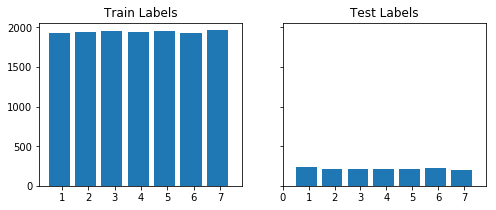

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=True)
bins = np.arange(8) + 0.5
ax1.hist(y_train, bins, width = 0.8)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_title('Train Labels')
ax2.hist(y_test, bins, width = 0.8)
ax2.set_title('Test Labels')
plt.xticks(range(8))
plt.show()

In [9]:
print(stats.describe(y_train))
print(stats.describe(y_test))
for i in range(0, 8):
        print(f'i = {i}: Train Ct: {(y_train==i).sum():>5} | Test Ct: {(y_test==i).sum():>5}')

DescribeResult(nobs=13608, minmax=(1, 7), mean=4.0058054085831865, variance=3.9963652070788513, skewness=-0.0011413747338513856, kurtosis=-1.2481641180127208)
DescribeResult(nobs=1512, minmax=(1, 7), mean=3.947751322751323, variance=4.034991631037296, skewness=0.010853316785871835, kurtosis=-1.2670058892892788)
i = 0: Train Ct:     0 | Test Ct:     0
i = 1: Train Ct:  1926 | Test Ct:   234
i = 2: Train Ct:  1944 | Test Ct:   216
i = 3: Train Ct:  1950 | Test Ct:   210
i = 4: Train Ct:  1945 | Test Ct:   215
i = 5: Train Ct:  1951 | Test Ct:   209
i = 6: Train Ct:  1932 | Test Ct:   228
i = 7: Train Ct:  1960 | Test Ct:   200


It appears that our classes are quite well-balanced in both our training data and the test data.

This is good both because we will not need to deliberately compensate for imbalances and because our model will be unable to achieve reasonable performance simply by guessing the modal category. (Doing so would give accuracy on the training set of 1741/12096 = 0.145, and then accuracy on the test set of 411/3024 = 0.136.)

## Investigating a basic model

In [67]:
def CrossValidateModel(model, X, y, name="model", folds=5, verbose=False):
    '''Takes an sklearn or similar model, an X feature set, and a y label set.  
    It performs crossvalidation across n folds and prints the results.'''
    np.random.seed(10)
    
    reportFields = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    generalReport = {'micro avg': copy.deepcopy(reportFields), 
                     'macro avg': copy.deepcopy(reportFields), 
                     'weighted avg':copy.deepcopy(reportFields)}
    for key in label_names:
        generalReport[key] = copy.deepcopy(reportFields)
    
    skf = StratifiedKFold(n_splits=folds, shuffle=True)
    for train_indexes, valid_indexes in skf.split(X, y):
        foldXTrain, foldYTrain = X.iloc[train_indexes], y.iloc[train_indexes]
        foldXValid, foldYValid = X.iloc[valid_indexes], y.iloc[valid_indexes] 

        model.fit(foldXTrain, foldYTrain)
        foldValidPred = model.predict(foldXValid)
        foldReport = metrics.classification_report(foldValidPred, foldYValid, output_dict=True)
        
        for key in foldReport:
            for outputField in reportFields:
                generalReport[key][outputField].append(foldReport[key][outputField])
    title = f'Model: {name}'
    if verbose: title += f', with {folds} folds' 
    print(title)
    
    fields = sorted(generalReport.keys()) if verbose else ['weighted avg']
    fieldLabels = [label_names[field] if field in label_names.keys() else field for field in fields]
    
    for i in range(len(fields)):
        output = f'\t{fieldLabels[i]:<20} | '
        for outputField in reportFields:
            output += f'{outputField}: {np.mean(generalReport[fields[i]][outputField]):>5.2f} | '
        print(output)
    if verbose: print()

Without _a priori_ knowledge of how the interplay between soil types, topography, hydrology, etc. affects forest cover, we may not necessarily have a strong bias toward starting with a given model.

### Naïve Bayes

One reasonable place to begin might be a Naïve Bayes classifier. While it is unlikely that all of the features at our disposal are _strictly_ independent, we may be able to relax the assumption of independence enough to explore how a NB model performs.

We don't want a Bernoulli NB model: our features are not uniformly binary-valued. We also don't want a Multinomial NB model: per the documentation, it assumes integer feature counts. A Gaussian NB, on the other hand, might work well. While it assumes that the likelihoods of the features are Gaussian - and this is not necessarily strictly the case - it may be worth trying.

In [68]:
# Testing on the unscaled data
CrossValidateModel(GaussianNB(), X_train, y_train, name='GaussianNB', verbose=True)

Model: GaussianNB, with 5 folds
	Spruce/Fir           | precision:  0.72 | recall:  0.50 | f1-score:  0.59 | support: 562.80 | 
	Lodgepole Pine       | precision:  0.13 | recall:  0.73 | f1-score:  0.22 | support: 71.60 | 
	Ponderosa Pine       | precision:  0.73 | recall:  0.43 | f1-score:  0.54 | support: 666.40 | 
	Cottonwood/Willow    | precision:  0.92 | recall:  0.68 | f1-score:  0.78 | support: 524.00 | 
	Aspen                | precision:  0.73 | recall:  0.59 | f1-score:  0.65 | support: 489.20 | 
	Douglas Fir          | precision:  0.07 | recall:  0.77 | f1-score:  0.12 | support: 33.60 | 
	Krummholz            | precision:  0.82 | recall:  0.86 | f1-score:  0.84 | support: 374.00 | 
	macro avg            | precision:  0.59 | recall:  0.65 | f1-score:  0.54 | support: 2721.60 | 
	micro avg            | precision:  0.59 | recall:  0.59 | f1-score:  0.59 | support: 2721.60 | 
	weighted avg         | precision:  0.76 | recall:  0.59 | f1-score:  0.65 | support: 2721.60 | 



One of the easiest metrics to use for determining the effectiveness of a model is simply its precision.  All in all, just throwing a Naive Bayes classifier at the data performed better than expected.  It achieved a 76% weighted accuracy across 5 fold cross validation.  A couple things stand out however, namely its performance on specific labels of the data.  This model performs very poorly on `Lodgepole Pine` and `Douglas Fir`, while performing extremely well on `Cottonwood/Willow`.  

## Initial standardizations of the data

#### MinMax Feature Scaling [-1,1]

As we can see from the initial summaries of our data above, the scales of the features vary widely. We can preprocess our data using the `MinMaxScaler` module, resulting in a dataset where all features fit within a given range. A range of [-1, 1] may be preferable to a range of [0, 1] because the `Elevation` and `Vertical_Distance_To_Hydrology` variables could legitimately include negative values. (`Elevation` does not, at least in our training data, but it could.) By ensuring all features exist within a given range, we eliminate the possibility that a feature could dominate the weighting and prediction process simply by virtue of having a range that is a few orders of magnitude greater than that of another (potentially more meaningful) feature. 

In [81]:
mm_scaler_neg1_1 = MinMaxScaler(feature_range=(-1, 1))
mm_X_scaled_neg1_1 = mm_scaler_neg1_1.fit_transform(X_train)

# Quick look to see if it behaved as expected
print(mm_X_scaled_neg1_1.shape)
mm_neg1_1_scaled_df = pd.DataFrame(data=mm_X_scaled_neg1_1,    # values
                         columns=X_train.columns)  # 1st row as the column names
# scaled_as_df = pd.DataFrame.from_array(X_scaled)
mm_neg1_1_scaled_df.head(10)

(13608, 54)


C:\Users\jakem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.112790,-0.644444,-0.153846,-0.900223,-0.534286,-0.812171,0.842520,0.161290,-0.379032,-0.830688,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-0.503525,-0.616667,-0.153846,-0.728965,-0.337143,-0.795202,0.866142,0.200000,-0.387097,-0.740312,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-0.325277,-0.700000,-0.769231,-0.865972,-0.577143,-0.266823,0.763780,0.651613,0.112903,-0.304733,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-0.441088,0.944444,-0.346154,-0.873418,-0.540000,-0.596255,0.472441,0.419355,0.282258,-0.876162,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-0.673716,0.277778,0.115385,-0.256888,-0.171429,-0.841720,0.267717,0.961290,0.717742,-0.730588,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-0.197382,-0.983333,-0.653846,-0.557707,-0.411429,-0.617613,0.629921,0.587097,0.225806,-0.642786,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,0.589124,0.322222,-0.615385,0.174981,0.105714,-0.373903,0.582677,0.935484,0.491935,-0.706278,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
7,-0.803625,0.877778,-0.423077,-1.000000,-0.582857,-0.739614,0.472441,0.535484,0.370968,-0.918490,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,-0.536757,-0.555556,-0.192308,-0.910648,-0.465714,-0.628730,0.913386,0.264516,-0.403226,-0.747462,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,-0.498489,0.955556,-0.384615,-0.700670,-0.285714,-0.593329,0.496063,0.445161,0.274194,-0.696840,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Scaling data to the range [-1, 1] appears to result in values that are incoherent. For instance, the values for the `Slope` and `Horizontal_Distance_To_Hydrology` features are now negative, which does not make conceptual sense. 

In [72]:
# Testing on the [-1,1] scaled data
CrossValidateModel(GaussianNB(), neg1_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [-1,1]', verbose=True)
# Testing on the unscaled data again for reference
CrossValidateModel(GaussianNB(), X_train, y_train, name='GaussianNB')

Model: GaussianNB, MinMax scaled [-1,1], with 5 folds
	Spruce/Fir           | precision:  0.14 | recall:  0.46 | f1-score:  0.21 | support: 114.80 | 
	Lodgepole Pine       | precision:  0.01 | recall:  0.58 | f1-score:  0.02 | support:  6.00 | 
	Ponderosa Pine       | precision:  0.39 | recall:  0.37 | f1-score:  0.38 | support: 415.60 | 
	Cottonwood/Willow    | precision:  1.00 | recall:  0.46 | f1-score:  0.63 | support: 838.40 | 
	Aspen                | precision:  0.66 | recall:  0.50 | f1-score:  0.57 | support: 514.60 | 
	Douglas Fir          | precision:  0.08 | recall:  0.42 | f1-score:  0.14 | support: 89.40 | 
	Krummholz            | precision:  0.97 | recall:  0.51 | f1-score:  0.67 | support: 742.80 | 
	macro avg            | precision:  0.46 | recall:  0.47 | f1-score:  0.37 | support: 2721.60 | 
	micro avg            | precision:  0.47 | recall:  0.47 | f1-score:  0.47 | support: 2721.60 | 
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | suppo

This test is to determine how much the scaled features affect the GaussianNB model, so we have included the previous basic GaussianNB results for referance.  First, looking at the weighted averages we can see that our precision rose slightly, while our recall dropped by about 0.12.  This means that with the scaled features we get more of the labels correct, but we get fewer of the relevant results correct.  Looking at each label specifically we can see that `Cottonwood/Willow` jumps up to 1.00 precision and 0.46 recall, this is very suprising as 100% precision is very rare.  

#### MinMax Feature Scaling [0,1]

 An alternative scaling may be in order, such as one that establishes 0 as a lower bound.  This will ensure that the majority of our features make sense when scaled.  This will make features like `Slope` and `Horizontal_Distance_To_Hydrology` make more sense.  It will also keep our binary features the same.

In [82]:
mm_scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
mm_X_scaled_0_1 = mm_scaler_0_1.fit_transform(X_train)
# Quick look to see if it behaved as expected
print(mm_X_scaled_0_1.shape)
mm_0_1_scaled_df = pd.DataFrame(data=mm_X_scaled_0_1,    # values
                         columns=X_train.columns)  # 1st row as the column names
mm_0_1_scaled_df.head(10)

(13608, 54)


C:\Users\jakem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.556395,0.177778,0.423077,0.049888,0.232857,0.093915,0.921260,0.580645,0.310484,0.084656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.248238,0.191667,0.423077,0.135517,0.331429,0.102399,0.933071,0.600000,0.306452,0.129844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.337362,0.150000,0.115385,0.067014,0.211429,0.366589,0.881890,0.825806,0.556452,0.347633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.279456,0.972222,0.326923,0.063291,0.230000,0.201872,0.736220,0.709677,0.641129,0.061919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.163142,0.638889,0.557692,0.371556,0.414286,0.079140,0.633858,0.980645,0.858871,0.134706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.401309,0.008333,0.173077,0.221147,0.294286,0.191194,0.814961,0.793548,0.612903,0.178607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.794562,0.661111,0.192308,0.587491,0.552857,0.313049,0.791339,0.967742,0.745968,0.146861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.098187,0.938889,0.288462,0.000000,0.208571,0.130193,0.736220,0.767742,0.685484,0.040755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.231621,0.222222,0.403846,0.044676,0.267143,0.185635,0.956693,0.632258,0.298387,0.126269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.250755,0.977778,0.307692,0.149665,0.357143,0.203335,0.748031,0.722581,0.637097,0.151580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The results of the alternative scaler using the range [0, 1] seem to be a little more coherent. The primary feature whose transformation may be unexpected would be the `Vertical_Distance_To_Hydrology`, because in unscaled form it contained negative values. We should examine it under scaled conditions.

In [76]:
five_num_summary(b_scaled_df, 'Vertical_Distance_To_Hydrology')

Column: Vertical_Distance_To_Hydrology      | Max value:    1.0 | Min value:    0.00 | Mean:    0.28 | Median:    0.26


In [83]:
# Testing on the [0,1] scaled data
CrossValidateModel(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]', verbose=True)

Model: GaussianNB, MinMax scaled [0,1], with 5 folds
	Spruce/Fir           | precision:  0.14 | recall:  0.46 | f1-score:  0.21 | support: 114.80 | 
	Lodgepole Pine       | precision:  0.01 | recall:  0.58 | f1-score:  0.02 | support:  6.00 | 
	Ponderosa Pine       | precision:  0.39 | recall:  0.37 | f1-score:  0.38 | support: 415.60 | 
	Cottonwood/Willow    | precision:  1.00 | recall:  0.46 | f1-score:  0.63 | support: 838.40 | 
	Aspen                | precision:  0.66 | recall:  0.50 | f1-score:  0.57 | support: 514.60 | 
	Douglas Fir          | precision:  0.08 | recall:  0.42 | f1-score:  0.14 | support: 89.40 | 
	Krummholz            | precision:  0.97 | recall:  0.51 | f1-score:  0.67 | support: 742.80 | 
	macro avg            | precision:  0.46 | recall:  0.47 | f1-score:  0.37 | support: 2721.60 | 
	micro avg            | precision:  0.47 | recall:  0.47 | f1-score:  0.47 | support: 2721.60 | 
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | suppor

In [85]:
# Testing on the [0,1] scaled data
CrossValidateModel(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]', verbose=True)
# Testing on the [-1,1] scaled data again for reference
CrossValidateModel(GaussianNB(), mm_neg1_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [-1,1]', verbose=True)
# Testing on the unscaled data again for reference
CrossValidateModel(GaussianNB(), X_train, y_train, name='GaussianNB')

Model: GaussianNB, MinMax scaled [0,1], with 5 folds
	Spruce/Fir           | precision:  0.14 | recall:  0.46 | f1-score:  0.21 | support: 114.80 | 
	Lodgepole Pine       | precision:  0.01 | recall:  0.58 | f1-score:  0.02 | support:  6.00 | 
	Ponderosa Pine       | precision:  0.39 | recall:  0.37 | f1-score:  0.38 | support: 415.60 | 
	Cottonwood/Willow    | precision:  1.00 | recall:  0.46 | f1-score:  0.63 | support: 838.40 | 
	Aspen                | precision:  0.66 | recall:  0.50 | f1-score:  0.57 | support: 514.60 | 
	Douglas Fir          | precision:  0.08 | recall:  0.42 | f1-score:  0.14 | support: 89.40 | 
	Krummholz            | precision:  0.97 | recall:  0.51 | f1-score:  0.67 | support: 742.80 | 
	macro avg            | precision:  0.46 | recall:  0.47 | f1-score:  0.37 | support: 2721.60 | 
	micro avg            | precision:  0.47 | recall:  0.47 | f1-score:  0.47 | support: 2721.60 | 
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | suppor

This test is to determine how much the range of the scaled features affect the GaussianNB model, so we have included the previous basic GaussianNB results for reference.  It appears that the range that the features are scaled to does not change the results.  This makes sense as the ratios between the features are linear to each other when using a MinMaxScaler.  To prove this we can test with a wildly different range like [200, 300]

#### MinMax Feature Scaling [200,300]

In [87]:
mm_scaler_200_300 = MinMaxScaler(feature_range=(200, 300))
mm_X_scaled_200_300 = mm_scaler_200_300.fit_transform(X_train)
# Quick look to see if it behaved as expected
mm_200_300_scaled_df = pd.DataFrame(data=mm_X_scaled_200_300,    # values
                         columns=X_train.columns)  # 1st row as the column names
# Testing on the [0,1] scaled data
CrossValidateModel(GaussianNB(), mm_200_300_scaled_df, y_train, name='GaussianNB, MinMax scaled [200,300]')
# Testing on the [-1,1] scaled data
CrossValidateModel(GaussianNB(), mm_neg1_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [-1,1]')
# Testing on the [0,1] scaled data
CrossValidateModel(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]')

C:\Users\jakem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Model: GaussianNB, MinMax scaled [200,300]
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | support: 2721.60 | 
Model: GaussianNB, MinMax scaled [-1,1]
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | support: 2721.60 | 
Model: GaussianNB, MinMax scaled [0,1]
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | support: 2721.60 | 


#### Standard Feature Scaling [0,1]

The `MinMaxScaler` linearly scales things to a unit range corresponding to the min and max of each feature.  This has the effect of grouping inliers together and making the data very narrow.  The `StandardScaler` scales the data to be within [0,1] by default, and also scales the data to a unit variance.  Using the `Standard Scaler` should help our scaled data stay in nice distributions.

In [95]:
s_scaler = StandardScaler()
s_X_scaled = s_scaler.fit_transform(X_train)
# Quick look to see if it behaved as expected
print(s_X_scaled.shape)
s_scaled_df = pd.DataFrame(data=s_X_scaled,    # values
                         columns=X_train.columns)  # 1st row as the column names
s_scaled_df.head(10)

(13608, 54)


C:\Users\jakem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jakem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.524048,-0.846207,0.645370,-0.764506,-0.558748,-0.807802,0.694371,-1.307127,-1.259549,-0.834120,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919
1,-0.942188,-0.800788,0.645370,-0.219322,0.563945,-0.763844,0.792354,-1.175931,-1.281289,-0.545296,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919
2,-0.518129,-0.937044,-1.247065,-0.655470,-0.802812,0.604931,0.367762,0.354698,0.066577,0.846726,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919
3,-0.793647,1.751748,0.053984,-0.679173,-0.591290,-0.248469,-0.840693,-0.432483,0.523113,-0.979446,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919
4,-1.347079,0.661697,1.473311,1.283491,1.507658,-0.884350,-1.689877,1.404272,1.697061,-0.514220,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919
5,-0.213861,-1.400316,-0.892233,0.325862,0.140901,-0.303796,-0.187474,0.136037,0.370934,-0.233622,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919
6,1.657266,0.734367,-0.773956,2.658303,3.085936,0.327538,-0.383440,1.316807,1.088347,-0.436530,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,4.377214,-0.213266,-0.174919
7,-1.656139,1.642743,-0.182570,-1.082136,-0.835354,-0.619842,-0.840693,-0.038892,0.762250,-1.114718,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919
8,-1.021249,-0.700866,0.527093,-0.797692,-0.168246,-0.332596,0.988320,-0.957269,-1.324769,-0.568146,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919
9,-0.930209,1.769915,-0.064293,-0.129248,0.856821,-0.240890,-0.742710,-0.345018,0.501373,-0.406368,...,-0.149116,-0.218856,-0.206201,-0.039314,-0.08205,-0.025726,-0.044588,-0.228456,-0.213266,-0.174919


In [92]:
# Testing on the [0,1] scaled data
CrossValidateModel(GaussianNB(), s_scaled_df, y_train, name='GaussianNB, Standard scaled [0,1]', verbose=True)
# Testing on the unscaled data again for reference
CrossValidateModel(GaussianNB(), X_train, y_train, name='GaussianNB')

Model: GaussianNB, Standard scaled [0,1], with 5 folds
	Spruce/Fir           | precision:  0.08 | recall:  0.33 | f1-score:  0.13 | support: 87.40 | 
	Lodgepole Pine       | precision:  0.01 | recall:  0.67 | f1-score:  0.01 | support:  4.80 | 
	Ponderosa Pine       | precision:  0.39 | recall:  0.37 | f1-score:  0.38 | support: 414.20 | 
	Cottonwood/Willow    | precision:  1.00 | recall:  0.46 | f1-score:  0.63 | support: 839.80 | 
	Aspen                | precision:  0.62 | recall:  0.49 | f1-score:  0.54 | support: 503.80 | 
	Douglas Fir          | precision:  0.09 | recall:  0.30 | f1-score:  0.14 | support: 130.80 | 
	Krummholz            | precision:  0.97 | recall:  0.51 | f1-score:  0.67 | support: 740.80 | 
	macro avg            | precision:  0.45 | recall:  0.45 | f1-score:  0.36 | support: 2721.60 | 
	micro avg            | precision:  0.45 | recall:  0.45 | f1-score:  0.45 | support: 2721.60 | 
	weighted avg         | precision:  0.76 | recall:  0.45 | f1-score:  0.55 | supp

This result is very interesting, the `StandardScaler` acutally performs slightly worse than the `MinMaxScaler` when used on a GaussianNB model.  The two perform very similarly by all measures, but the `StandardScaler` is just slightly worse.

#### Robust Feature Scaling

The `RobustScaler` behaves very similarly to the `MinMaxScaler` but it uses the inter-quartile range to scale features rather than just min and max.  This should allow it to be more robust to outliers in the data.

In [96]:
r_scaler = RobustScaler()
r_X_scaled = r_scaler.fit_transform(X_train)
# Quick look to see if it behaved as expected
print(r_X_scaled.shape)
r_scaled_df = pd.DataFrame(data=r_X_scaled,    # values
                         columns=X_train.columns)  # 1st row as the column names
r_scaled_df.head(10)

(13608, 54)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.297799,-0.316327,0.583333,-0.429658,-0.206667,-0.443780,0.358974,-1.196429,-1.000000,-0.525896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.544017,-0.290816,0.583333,0.007605,0.713333,-0.405248,0.435897,-1.089286,-1.016393,-0.274104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.300550,-0.367347,-0.750000,-0.342205,-0.406667,0.794552,0.102564,0.160714,0.000000,0.939442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.458735,1.142857,0.166667,-0.361217,-0.233333,0.046504,-0.846154,-0.482143,0.344262,-0.652590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.776479,0.530612,1.166667,1.212928,1.486667,-0.510879,-1.512821,1.017857,1.229508,-0.247012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.125860,-0.627551,-0.500000,0.444867,0.366667,-0.001993,-0.333333,-0.017857,0.229508,-0.002390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.948418,0.571429,-0.416667,2.315589,2.780000,0.551403,-0.487179,0.946429,0.770492,-0.179283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,-0.953920,1.081633,0.000000,-0.684411,-0.433333,-0.279023,-0.846154,-0.160714,0.524590,-0.770518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.589409,-0.234694,0.500000,-0.456274,0.113333,-0.027238,0.589744,-0.910714,-1.049180,-0.294024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.537139,1.153061,0.083333,0.079848,0.953333,0.053147,-0.769231,-0.410714,0.327869,-0.152988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
# Testing on the Robust scaled data
CrossValidateModel(GaussianNB(), r_scaled_df, y_train, name='GaussianNB, Robust scaled [0,1]', verbose=True)
# Testing on the unscaled data again for reference
CrossValidateModel(GaussianNB(), X_train, y_train, name='GaussianNB')
# Testing on the [0,1] scaled data
CrossValidateModel(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]')

Model: GaussianNB, Robust scaled [0,1], with 5 folds
	Spruce/Fir           | precision:  0.16 | recall:  0.49 | f1-score:  0.24 | support: 123.80 | 
	Lodgepole Pine       | precision:  0.01 | recall:  0.56 | f1-score:  0.02 | support:  6.80 | 
	Ponderosa Pine       | precision:  0.40 | recall:  0.37 | f1-score:  0.38 | support: 419.00 | 
	Cottonwood/Willow    | precision:  1.00 | recall:  0.46 | f1-score:  0.63 | support: 835.00 | 
	Aspen                | precision:  0.68 | recall:  0.50 | f1-score:  0.57 | support: 531.40 | 
	Douglas Fir          | precision:  0.08 | recall:  0.44 | f1-score:  0.14 | support: 82.60 | 
	Krummholz            | precision:  0.97 | recall:  0.53 | f1-score:  0.68 | support: 723.00 | 
	macro avg            | precision:  0.47 | recall:  0.48 | f1-score:  0.38 | support: 2721.60 | 
	micro avg            | precision:  0.47 | recall:  0.47 | f1-score:  0.47 | support: 2721.60 | 
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | suppor

The `RobustScaler` averages out to the same performance as the others.

#### Normalizer Feature Scaling

The `Normalizer` is a very extreme form of normalization that is generally used when all of the features are in similar ranges.  What is does is scales all features to the same range, and basically forms a hypersphere of all the feature maxes.  This means that all features are within 1 unit length of the center via cartesian distance across all feature planes.  This is not an ideal case for this scaler, but it may be interesting to see what happens.

In [99]:
n_scaler = Normalizer()
n_X_scaled = n_scaler.fit_transform(X_train)
# Quick look to see if it behaved as expected
print(n_X_scaled.shape)
n_scaled_df = pd.DataFrame(data=n_X_scaled,    # values
                         columns=X_train.columns)  # 1st row as the column names
n_scaled_df.head(10)

(13608, 54)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.954079,0.020573,0.007072,0.021537,0.005465,0.206374,0.075220,0.060755,0.024752,0.190301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.889863,0.026061,0.008309,0.068742,0.032482,0.264391,0.089515,0.072519,0.028705,0.342952,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.585163,0.012475,0.001386,0.020791,0.000462,0.578926,0.051748,0.052441,0.031880,0.561600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.845807,0.122429,0.005947,0.029733,0.005247,0.482719,0.065412,0.073107,0.055618,0.151462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.863087,0.090768,0.011445,0.196928,0.056829,0.213503,0.063538,0.099056,0.084059,0.371755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.818908,0.000924,0.002771,0.091434,0.018472,0.402373,0.063727,0.068345,0.046795,0.384517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.803306,0.055561,0.002335,0.184193,0.056262,0.499586,0.046924,0.058129,0.043188,0.239755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000233,0.0,0.0
7,0.891038,0.146342,0.006494,0.000000,0.000000,0.385337,0.080964,0.094386,0.073604,0.123395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.826390,0.028459,0.007471,0.021345,0.014585,0.451437,0.086445,0.070081,0.026325,0.314121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.790921,0.117918,0.005360,0.067334,0.034839,0.465642,0.063649,0.070684,0.052929,0.355094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [100]:
# Testing on the Normalized data
CrossValidateModel(GaussianNB(), n_scaled_df, y_train, name='GaussianNB, Normalized', verbose=True)
# Testing on the unscaled data again for reference
CrossValidateModel(GaussianNB(), X_train, y_train, name='GaussianNB')
# Testing on the [0,1] scaled data
CrossValidateModel(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]')

Model: GaussianNB, Normalized, with 5 folds
	Spruce/Fir           | precision:  0.52 | recall:  0.48 | f1-score:  0.50 | support: 421.40 | 
	Lodgepole Pine       | precision:  0.11 | recall:  0.83 | f1-score:  0.20 | support: 54.20 | 
	Ponderosa Pine       | precision:  0.75 | recall:  0.42 | f1-score:  0.54 | support: 695.00 | 
	Cottonwood/Willow    | precision:  0.88 | recall:  0.68 | f1-score:  0.77 | support: 505.40 | 
	Aspen                | precision:  0.66 | recall:  0.51 | f1-score:  0.58 | support: 505.40 | 
	Douglas Fir          | precision:  0.06 | recall:  0.66 | f1-score:  0.10 | support: 33.00 | 
	Krummholz            | precision:  0.84 | recall:  0.65 | f1-score:  0.74 | support: 507.20 | 
	macro avg            | precision:  0.55 | recall:  0.60 | f1-score:  0.49 | support: 2721.60 | 
	micro avg            | precision:  0.55 | recall:  0.55 | f1-score:  0.55 | support: 2721.60 | 
	weighted avg         | precision:  0.72 | recall:  0.55 | f1-score:  0.61 | support: 2721.6

Not surprisingly the `Normalizer` did not improve the results on this data set.  This is likely because the features have such extreme differences in ranges and variances.  For example, the `Slope` feature goes from 0-54, while the `Horizontal_Distance_To_Fire_Points` ranges from 0-6993.

## Master Model Result List

In [102]:
with warnings.catch_warnings(record=False):
    # Testing on the unscaled data
    CrossValidateModel(GaussianNB(), X_train, y_train, name='GaussianNB')
    # Testing on the [-1,1] scaled data
    CrossValidateModel(GaussianNB(), mm_neg1_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [-1,1]')
    # Testing on the [0,1] scaled data
    CrossValidateModel(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]')
    # Testing on the Robust scaled data
    CrossValidateModel(GaussianNB(), r_scaled_df, y_train, name='GaussianNB, Robust scaled [0,1]')
    # Testing on the Normalized data
    CrossValidateModel(GaussianNB(), n_scaled_df, y_train, name='GaussianNB, Normalized')

Model: GaussianNB
	weighted avg         | precision:  0.76 | recall:  0.59 | f1-score:  0.65 | support: 2721.60 | 
Model: GaussianNB, MinMax scaled [-1,1]
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | support: 2721.60 | 
Model: GaussianNB, MinMax scaled [0,1]
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | support: 2721.60 | 
Model: GaussianNB, Robust scaled [0,1]
	weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | support: 2721.60 | 
Model: GaussianNB, Normalized
	weighted avg         | precision:  0.72 | recall:  0.55 | f1-score:  0.61 | support: 2721.60 | 
